In [1]:
import numpy as np
import pandas as pd
import os

import re
from datetime import datetime as time
from ast import literal_eval
from sklearn.model_selection import train_test_split

import artm
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gc
import matplotlib.pyplot as plt
%matplotlib inline

/home/vtrokhymenko/proj_news_viz/env4news/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
!ls -lah data/*.csv.bz2

-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 491K Jan 15 18:18 data/69-.paralel.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  48M Jan 15 18:21 data/Russia.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  12M Jan 15 18:21 data/Sil_struktur.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  44K Jan 15 18:19 data/biblioteka.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  25M Jan 15 18:19 data/bivs.SSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 6.1M Jan 15 18:18 data/biznes.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 2.9M Jan 15 18:21 data/cennosti.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  28M Jan 15 18:21 data/economic.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  16M Jan 15 18:19 data/internet.i.smi.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 8.6M Jan 15 18:18 data/iz.jizni.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 125K Jan 15 18:18 data/kultprosvet.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  20M Jan 15 18:18 data/kultura.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 

In [3]:
name_dataset = 'internet.i.smi'

### load data

In [4]:
%%time
df = pd.read_csv(f'data/{name_dataset}.csv.bz2')
print(df.shape)

(37224, 7)
CPU times: user 11.1 s, sys: 144 ms, total: 11.3 s
Wall time: 11.6 s


In [5]:
df = df[df.text!='text']
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/dvd/,NaN,Россия,"В Москве открылась выставка ""DVD-шоу'99""","1 октября в Москве в отеле ""Аэростар"" открылас...",Интернет и СМИ
1,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/scouts/,NaN,Мир,Украинский порносайт унаследовал домен девочек...,"Украинский порнографический сайт занял домен, ...",Интернет и СМИ


### preprocess

* get dates

In [6]:
%%time

df['date_raw'] = df['url'].apply(re.compile('(\d{4})/(\d{2})/(\d{2})').findall)

df['year'] = df['date_raw'].apply(lambda x: int(x[0][0]))
df['month'] = df['date_raw'].apply(lambda x: int(x[0][1]))

<unknown>:2: DeprecationWarning: invalid escape sequence \d


CPU times: user 205 ms, sys: 15.4 ms, total: 221 ms
Wall time: 234 ms


* clean text

In [7]:
import preprocessing_tools as pr

In [8]:
%%time
df.text = df.text.apply(pr.clean_text)

CPU times: user 9.6 s, sys: 98.2 ms, total: 9.7 s
Wall time: 10.1 s


In [9]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic,date_raw,year,month
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/dvd/,NaN,Россия,"В Москве открылась выставка ""DVD-шоу'99""",октября в москве в отеле аэростар открылась пе...,Интернет и СМИ,"[(1999, 10, 01)]",1999,10
1,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/scouts/,NaN,Мир,Украинский порносайт унаследовал домен девочек...,украинский порнографический сайт занял домен р...,Интернет и СМИ,"[(1999, 10, 01)]",1999,10


* cleanedNames

In [10]:
from cleanedNames import KeyProc
cn = KeyProc()

In [11]:
%%time
df.text = df.text.apply(cn.replaceKeywords)

CPU times: user 1min 36s, sys: 29.1 ms, total: 1min 36s
Wall time: 1min 41s


* lemmatization

In [12]:
%%time
df['lemmatized_text'] = df.text.apply(pr.lemmatization)

CPU times: user 2min 56s, sys: 396 ms, total: 2min 57s
Wall time: 3min 4s


* add docID

In [13]:
df['docID'] = list(range(df.shape[0]))

In [14]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
0,0,1999,10,"[октябрь, москва, отель, аэростарый, открыться..."
1,1,1999,10,"[украинский, порнографический, сайт, занять, д..."


In [15]:
print(df.shape)
df.isnull().sum()

(37224, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [16]:
df.year.min()

1999

## model

* prepare

In [17]:
%%time

vwpath = f'data/vwpath/{name_dataset}_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

CPU times: user 759 ms, sys: 126 ms, total: 884 ms
Wall time: 920 ms


In [18]:
id_date = df[['docID', 'year', 'month']].copy()

* collect batchs and collect the dictionary

In [19]:
%%time

batches_path = f'data/batches/{name_dataset}'

if not os.path.exists(batches_path):
    print('create folder...\n')
    os.makedirs(batches_path)
    
batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

print(batch_vectorizer)

create folder...

artm.BatchVectorizer(data_path="data/batches/internet.i.smi", num_batches=38)
CPU times: user 27.5 s, sys: 936 ms, total: 28.5 s
Wall time: 16.7 s


In [20]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

In [21]:
dictionary.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=a05daeb2-904f-4c7b-b1d3-a3989292aecf, num_entries=22944)

In [22]:
dictionary.save_text(f'data/dicts/dict_{name_dataset}.txt')

## pick up amount topics

In [23]:
%%time
model_list = []
step, perplexity, sTheta, sPhi = [], [], [], []

for i in range(2,20+1,1):
    print(f'#topic {i}.........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)
    
    # scores
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary=dictionary))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

    # regularizers
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)
    model_list.append(model)
    
    sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
    sTheta.append(sparsityTheta)
    sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
    sPhi.append(sparsityPhi)
    perpl = model.score_tracker['PerplexityScore'].last_value
    perplexity.append(perpl)
    
    print(f'\tSparsityThetaScore: {sparsityTheta}')
    print(f'\tSparsityPhiScore: {sparsityPhi}')
    print(f'\tPerplexityScore: {perpl}')
    
    print('\ttime:',time.now()-date_start)
    
newTime = time.now() #

#topic 2.........
	SparsityThetaScore: 0.1208091527223587
	SparsityPhiScore: 0.25457635521888733
	PerplexityScore: 4854.35107421875
	time: 0:02:40.112641
#topic 3.........
	SparsityThetaScore: 0.2597696781158447
	SparsityPhiScore: 0.39449673891067505
	PerplexityScore: 4291.78369140625
	time: 0:02:59.652317
#topic 4.........
	SparsityThetaScore: 0.33282962441444397
	SparsityPhiScore: 0.49280858039855957
	PerplexityScore: 3997.1806640625
	time: 0:02:54.621216
#topic 5.........
	SparsityThetaScore: 0.3815602958202362
	SparsityPhiScore: 0.5556311011314392
	PerplexityScore: 3844.774658203125
	time: 0:03:29.641709
#topic 6.........
	SparsityThetaScore: 0.44411760568618774
	SparsityPhiScore: 0.5926676392555237
	PerplexityScore: 3639.90185546875
	time: 0:03:41.025864
#topic 7.........
	SparsityThetaScore: 0.47704246640205383
	SparsityPhiScore: 0.6213887333869934
	PerplexityScore: 3549.093017578125
	time: 0:03:49.879980
#topic 8.........
	SparsityThetaScore: 0.5143355131149292
	SparsityPhiScore

In [31]:
#model_list

Text(0.5, 1.0, 'SparsityPhiScore')

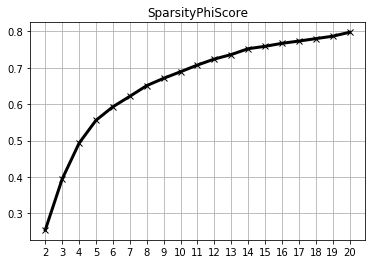

In [24]:
plt.plot(step, sPhi, color='k',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('SparsityPhiScore')

In [25]:
index_sphi = []
[index_sphi.append(float(str(i)[:3]) ) for i in sPhi]
    
index_sphi = list(set(index_sphi))
index_sphi.sort()
index_sphi

[0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [26]:
d_sphi = {}

for j in range(len(index_sphi)):
    k=0
    for i in sPhi:
        if j==range(len(index_sphi))[-1]:
            if (i>=index_sphi[j]):
                k+=1
        else:
            if (i>=index_sphi[j]) & (i<index_sphi[j+1]):
                k+=1
    d_sphi[index_sphi[j]]=k

d_sphi

{0.2: 1, 0.3: 1, 0.4: 1, 0.5: 2, 0.6: 4, 0.7: 10}

Text(0.5, 1.0, 'SparsityThetaScore')

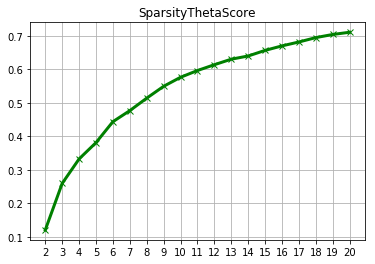

In [27]:
plt.plot(step, sTheta, color='g',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()

plt.title('SparsityThetaScore')

In [28]:
index_theta = []
[index_theta.append(float(str(i)[:3])) for i in sTheta]
    
index_theta = list(set(index_theta))
index_theta.sort()
index_theta

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [29]:
d_stheta = {}

for j in range(len(index_theta)):
    k=0
    for i in sTheta:
        if j==range(len(index_theta))[-1]:
            if (i>=index_theta[j]):
                k+=1
        else:
            if (i>=index_theta[j]) & (i<index_theta[j+1]):
                k+=1
    d_stheta[index_theta[j]]=k

d_stheta

{0.1: 1, 0.2: 1, 0.3: 2, 0.4: 2, 0.5: 4, 0.6: 7, 0.7: 2}

Text(0.5, 1.0, 'PerplexityScore')

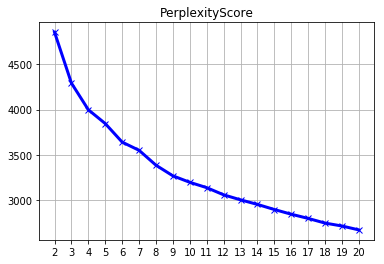

In [30]:
plt.plot(step, perplexity, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('PerplexityScore')

In [31]:
perplexity

[4854.35107421875,
 4291.78369140625,
 3997.1806640625,
 3844.774658203125,
 3639.90185546875,
 3549.093017578125,
 3384.486572265625,
 3267.139892578125,
 3195.555908203125,
 3136.456787109375,
 3057.3427734375,
 3001.895751953125,
 2951.2919921875,
 2894.868408203125,
 2842.95849609375,
 2796.48681640625,
 2744.826171875,
 2712.655517578125,
 2669.431396484375]

### select the best model

In [32]:
print(f'd_sphi:   {d_sphi}')
print(f'd_stheta: {d_stheta}')

d_sphi:   {0.2: 1, 0.3: 1, 0.4: 1, 0.5: 2, 0.6: 4, 0.7: 10}
d_stheta: {0.1: 1, 0.2: 1, 0.3: 2, 0.4: 2, 0.5: 4, 0.6: 7, 0.7: 2}


In [33]:
select_topics = 20 # u should choose number of topic

best_model = model_list[select_topics-2]
print(best_model.num_topics)

20


### print top words for each topics

In [34]:
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])

topic_0: ['apple' 'microsoft' 'музыкальный' 'авторский' 'музыка' 'контент'
 'браузер' 'файл' 'пиратский' 'music']
topic_1: ['иск' 'подать' 'судебный' 'рубль' 'адвокат' 'заявление' 'статья' 'эхо'
 'компенсация' 'требовать']
topic_2: ['британский' 'ребёнок' 'великобритания' 'bbc' 'бибись' 'ведущий' 'news'
 'daily' 'guardian' 'фунт']
topic_3: ['рекламный' 'оператор' 'услуга' 'кампания' 'бренд' 'город' 'рынок'
 'объявление' 'рубль' 'портал']
topic_4: ['домен' 'депутат' 'законопроект' 'правительство' 'общественный'
 'организация' 'информационный' 'доменный' 'регистрация' 'госдума']
topic_5: ['полиция' 'уголовный' 'задержать' 'статья' 'убийство' 'орган' 'обвинение'
 'расследование' 'правоохранительный' 'прокуратура']
topic_6: ['ролик' 'фильм' 'youtube' 'игра' 'премия' 'видео' 'сериал' 'хороший'
 'шоу' 'номинация']
topic_7: ['украина' 'украинский' 'военный' 'государство' 'организация' 'территория'
 'война' 'правительство' 'международный' 'свобода']
topic_8: ['times' 'news' 'yahoo' 'new' 'york

### get topics-docs matrix

shape theta: (20, 37224)


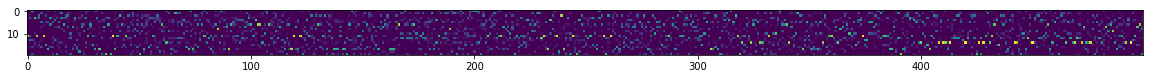

In [35]:
theta = best_model.transform_sparse(batch_vectorizer=batch_vectorizer, eps=0.001)
print(f'shape theta: {theta[0].shape}')

plt.figure(figsize=(20, 20))
plt.imshow(theta[0][:, 2000:2500].toarray());

### dense theta matrix

In [36]:
theta = best_model.transform(batch_vectorizer=batch_vectorizer)
theta = theta.T
theta.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
31000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.209707,0.0,0.000000,0.000000,0.000000,0.363265,0.000000,0.078808,0.000000,0.0,0.34822,0.0,0.000000,0.00000
31001,0.00000,0.000000,0.066897,0.000000,0.000000,0.000000,0.412317,0.0,0.158798,0.308842,0.000000,0.000000,0.000000,0.053146,0.000000,0.0,0.00000,0.0,0.000000,0.00000
31002,0.00000,0.110582,0.012260,0.000000,0.000000,0.650951,0.000000,0.0,0.000000,0.226207,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.00000
31003,0.00000,0.000000,0.000000,0.041060,0.162903,0.000000,0.000000,0.0,0.000000,0.000000,0.115529,0.000000,0.593097,0.000000,0.000000,0.0,0.00000,0.0,0.031770,0.05564
31004,0.08539,0.000000,0.000000,0.064223,0.673979,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.045373,0.000000,0.000000,0.107982,0.0,0.00000,0.0,0.023053,0.00000


## DataViz

In [37]:
joined = id_date.join(theta)
joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,1999,10,0.243972,0.0,0.000000,0.590758,0.000000,0.0,0.16527,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,1,1999,10,0.193507,0.0,0.000000,0.000000,0.448284,0.0,0.00000,...,0.000000,0.000000,0.000000,0.0,0.075057,0.028367,0.000000,0.107055,0.0,0.0
2,2,1999,10,0.342027,0.0,0.061620,0.163303,0.000000,0.0,0.00000,...,0.000000,0.223731,0.000000,0.0,0.000000,0.000000,0.018311,0.191007,0.0,0.0
3,3,1999,10,0.000000,0.0,0.051585,0.000000,0.079876,0.0,0.00000,...,0.040917,0.056065,0.022915,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,4,1999,10,0.000000,0.0,0.000000,0.255065,0.389863,0.0,0.00000,...,0.355072,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [38]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()
print(f'gb.shape: {gb.shape}')
gb.head()

gb.shape: (227, 20)


topic_0   topic_1   topic_2   topic_3    topic_4   topic_5  \
year month                                                                
1999 9      1.533218  2.999784  0.809985  1.262578   5.548168  2.140447   
     10     2.953811  3.563615  0.985246  5.069560  10.395182  1.922721   
     11     3.662245  5.455999  0.865839  3.080917   9.735193  4.332416   
     12     4.395304  3.489382  0.814605  4.927789  10.388089  2.111632   
2000 1      4.544326  1.841018  1.455181  3.023160   9.896037  2.412318   

             topic_6   topic_7   topic_8   topic_9  topic_10  topic_11  \
year month                                                               
1999 9      0.368500  3.121680  0.681411  1.680119  2.935788  0.469012   
     10     1.227878  1.543510  1.709624  1.149043  3.092802  1.461485   
     11     1.404121  1.739147  1.786219  2.153288  3.434577  1.332914   
     12     0.726138  3.168561  2.940989  1.999420  3.994606  1.531536   
2000 1      1.181715  3.733769  3.536169  2.696326  1.795881  2.923205   

            topic_12  topic_13  topic_14  topic_15  topic_16  topic_17  \
year month                                                               
1999 9      2.444213  0.939702  1.582186  0.960474  0.365542  3.131144   
     10     1.487475  1.573054  1.263756  4.301420  0.468586  3.764941   
     11     2.811229  4.257851  2.716908  4.278861  0.344669  4.357975   
     12     3.371969  1.943325  1.317524  2.282486  0.920436  6.374694   
2000 1      2.923479  2.013855  2.191576  1.655039  0.356787  8.160008   

            topic_18  topic_19  
year month                      
1999 9      0.493833  0.532216  
     10     0.301838  0.764453  
     11     2.874685  1.374948  
     12     1.266939  1.034575  
2000 1      2.167220  0.492930

### straightforward matrix heatmap

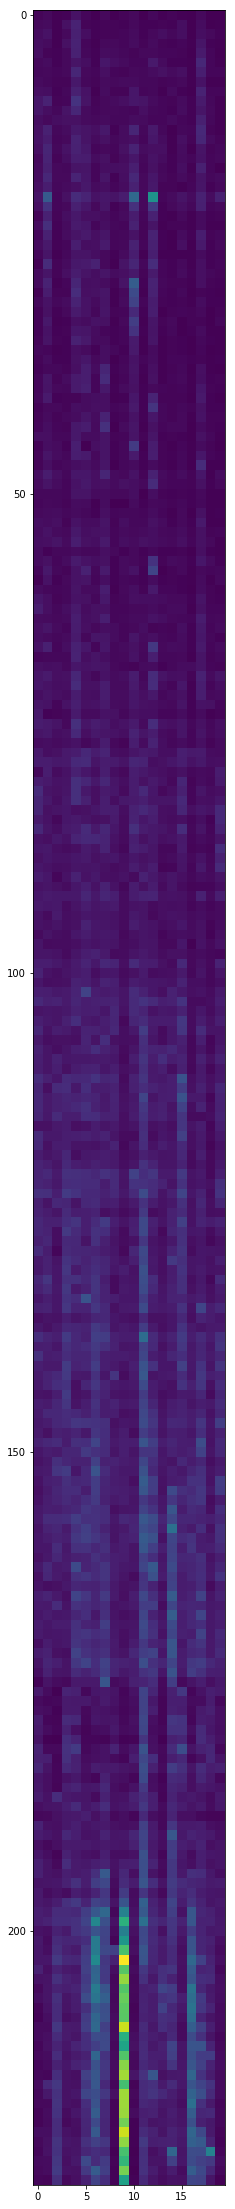

In [39]:
plt.figure(figsize=(10, 40))
plt.imshow(gb[topics])

## pygal

In [40]:
import pygal
from IPython.display import SVG, HTML

In [41]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [ ]:
line_chart = pygal.StackedLine(fill=True, show_dots=False)
line_chart.title = 'Topics'
for topic in topics:
    line_chart.add(topic, gb[topic].values)
    
HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

In [43]:
line_chart.render_to_file(f"data/visualization/{'-'.join(name_dataset.split('.'))}_pygal.svg")

## joypy

In [44]:
import joypy # !pip install joypy

In [45]:
print(joined.shape)
joined.head()

(37224, 23)


,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,1999,10,0.243972,0.0,0.000000,0.590758,0.000000,0.0,0.16527,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,1,1999,10,0.193507,0.0,0.000000,0.000000,0.448284,0.0,0.00000,...,0.000000,0.000000,0.000000,0.0,0.075057,0.028367,0.000000,0.107055,0.0,0.0
2,2,1999,10,0.342027,0.0,0.061620,0.163303,0.000000,0.0,0.00000,...,0.000000,0.223731,0.000000,0.0,0.000000,0.000000,0.018311,0.191007,0.0,0.0
3,3,1999,10,0.000000,0.0,0.051585,0.000000,0.079876,0.0,0.00000,...,0.040917,0.056065,0.022915,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,4,1999,10,0.000000,0.0,0.000000,0.255065,0.389863,0.0,0.00000,...,0.355072,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [46]:
joined['year_month'] = joined.apply(lambda x: str(int(x.year)) +'-'+ str(int(x.month)) + '-01', axis=1)
joined.reset_index(inplace=True)

joined.head()

,index,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,year_month
0,0,0,1999,10,0.243972,0.0,0.000000,0.590758,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1999-10-01
1,1,1,1999,10,0.193507,0.0,0.000000,0.000000,0.448284,0.0,...,0.000000,0.000000,0.0,0.075057,0.028367,0.000000,0.107055,0.0,0.0,1999-10-01
2,2,2,1999,10,0.342027,0.0,0.061620,0.163303,0.000000,0.0,...,0.223731,0.000000,0.0,0.000000,0.000000,0.018311,0.191007,0.0,0.0,1999-10-01
3,3,3,1999,10,0.000000,0.0,0.051585,0.000000,0.079876,0.0,...,0.056065,0.022915,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1999-10-01
4,4,4,1999,10,0.000000,0.0,0.000000,0.255065,0.389863,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1999-10-01


In [47]:
joined_melt = joined.melt('year_month', var_name='topic', value_name='text')
print(joined_melt.shape)
joined_melt.head()

(893376, 3)


,year_month,topic,text
0,1999-10-01,index,0.0
1,1999-10-01,index,1.0
2,1999-10-01,index,2.0
3,1999-10-01,index,3.0
4,1999-10-01,index,4.0


In [48]:
# select only topic_*
joined_melt_new = joined_melt[(joined_melt.topic!='docID') & (joined_melt.topic!='index')
                              & (joined_melt.topic!='year') & (joined_melt.topic!='month')]
print(joined_melt_new.shape)
joined_melt_new.topic.value_counts()

(744480, 3)


topic_9     37224
topic_6     37224
topic_19    37224
topic_2     37224
topic_11    37224
topic_4     37224
topic_18    37224
topic_10    37224
topic_17    37224
topic_15    37224
topic_8     37224
topic_0     37224
topic_3     37224
topic_7     37224
topic_14    37224
topic_5     37224
topic_12    37224
topic_16    37224
topic_13    37224
topic_1     37224
Name: topic, dtype: int64

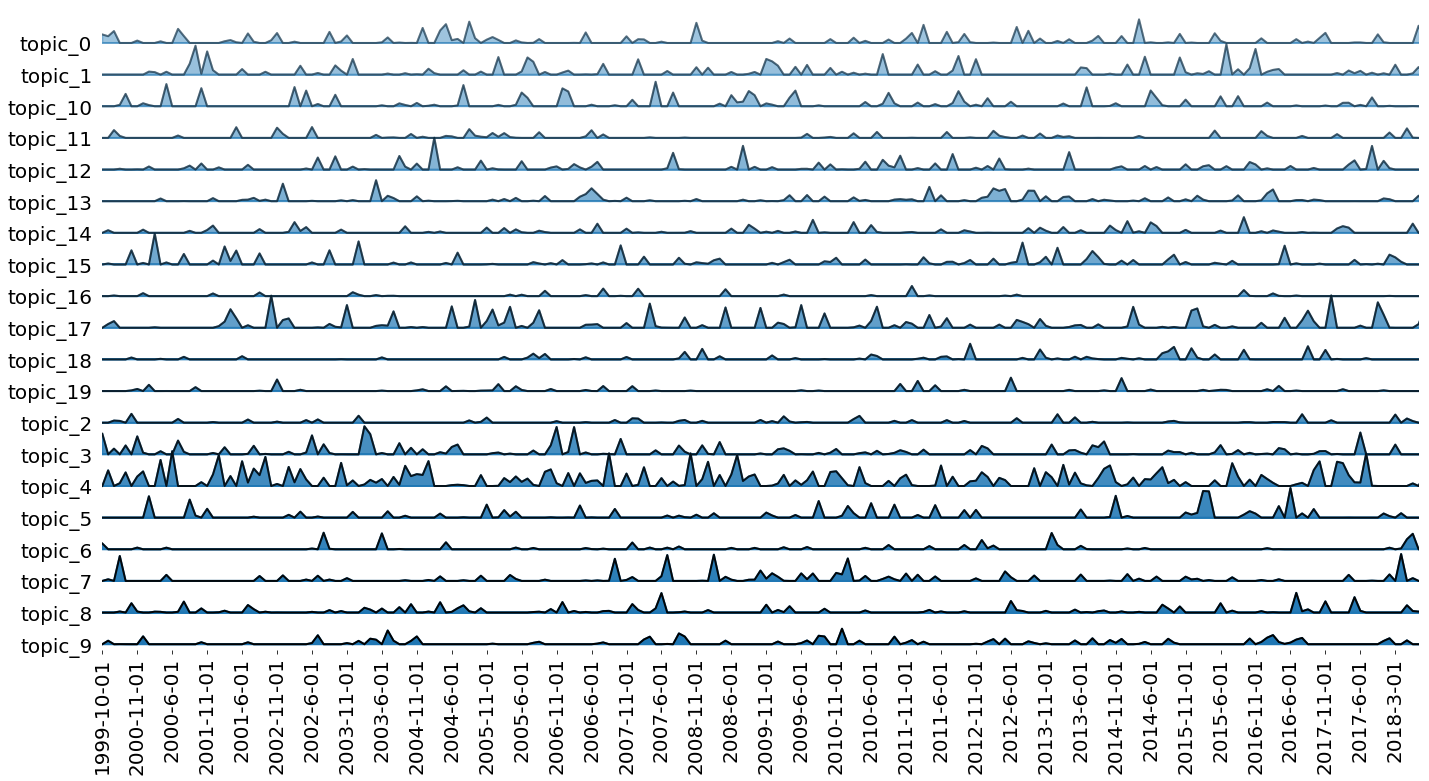

In [49]:
labels = sorted(joined_melt_new['year_month'].unique())

fig, axes = joypy.joyplot(joined_melt_new, by='topic', column='text', figsize=(20, 10),xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True, linecolor="k", linewidth=2,
                          kind='values', fade=True, xrot=90, x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

In [50]:
fig.savefig(f"data/visualization/{'-'.join(name_dataset.split('.'))}_joypy")